In [50]:
import pandas as pd
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from nltk import corpus
from gensim.models import word2vec
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import matplotlib.pyplot as plt

In [21]:
df=pd.read_csv("zomato.csv")

In [22]:
all_ratings = []

for name,ratings in tqdm(zip(df['name'],df['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])

51717it [00:23, 2181.37it/s]


In [23]:
all_ratings[:10]

[['Jalsa',
  4.0,
  'A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again.'],
 ['Jalsa',
  4.0,
  'I was here for dinner with my family on a weekday. The restaurant was completely empty. Ambience is good with some good old hindi music. Seating arrangement are good too. We ordered masala papad, panner and baby corn starters, lemon and corrionder soup, butter roti, olive and chilli paratha. Food was fresh and good, service is good too. Good for family hangout.\nCheers'],
 ['Jalsa',
  2.0,
  'Its a restaurant near to Banashankari BDA. Me along with few of my office friends visited to have buffet but unfortunately they only provide veg buffet. On inquiring they said this place is mostly visited by veg

In [24]:
rating_df=pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [25]:
rating_df.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...


In [26]:
rating_df['review'][:5]

0    A beautiful place to dine inThe interiors take...
1    I was here for dinner with my family on a week...
2    Its a restaurant near to Banashankari BDA Me a...
3    We went here on a weekend and one of us had th...
4    The best thing about the place is its ambiance...
Name: review, dtype: object

In [34]:
rating_df.to_csv("Ratings.csv")

In [35]:
rating_df['sent']=rating_df['rating'].apply(lambda x: 1 if int(x)>2.5 else 0)

In [39]:
stops=stopwords.words('english')
lem=WordNetLemmatizer()
corpus=' '.join(lem.lemmatize(x) for x in rating_df[rating_df['sent']==1]['review'][:3000] if x not in stops)
tokens=word_tokenize(corpus)

In [40]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)

In [41]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(rating_df['review'].values)
X = tokenizer.texts_to_sequences(rating_df['review'].values)
X = pad_sequences(X)

In [42]:
embed_dim = 32
lstm_out = 32

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
#model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 194, 32)           96000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 104,386
Trainable params: 104,386
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
Y = pd.get_dummies(rating_df['sent'].astype(int)).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 30)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(884378, 194) (884378, 2)
(435590, 194) (435590, 2)


In [44]:
batch_size = 3200
history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size)

C:\Users\varun\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
884378/884378 [==============================] - 816s 922us/step - loss: 0.2600 - accuracy: 0.8974
Epoch 2/5
884378/884378 [==============================] - 880s 995us/step - loss: 0.1553 - accuracy: 0.9404
Epoch 3/5
884378/884378 [==============================] - 890s 1ms/step - loss: 0.1382 - accuracy: 0.9478
Epoch 4/5
884378/884378 [==============================] - 984s 1ms/step - loss: 0.1262 - accuracy: 0.9530
Epoch 5/5
884378/884378 [==============================] - 1047s 1ms/step - loss: 0.1172 - accuracy: 0.9566


In [45]:
history

In [46]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)


score: 0.12
acc: 0.96


In [47]:
print("score: %.6f" % (score))
print("acc: %.6f" % (acc))

score: 0.117377
acc: 0.955984


In [48]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


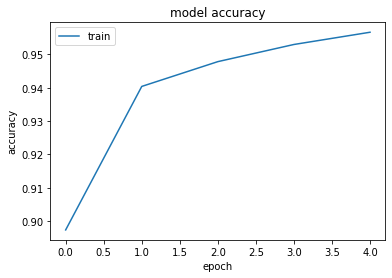

In [52]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

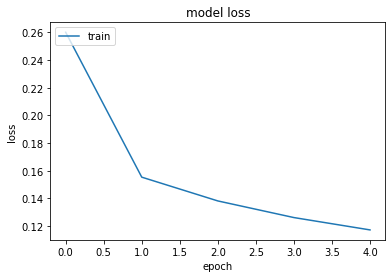

In [53]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()